In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import os

from PIL import ImageColor
from matplotlib.colors import rgb2hex
from generativepy.color import Color
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, LineString
from scipy.stats import gaussian_kde

pd.set_option('display.max_colwidth', 25)
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize']=(12, 6)

In [2]:
gdf = gpd.read_parquet('./gridData.geo.parquet')

world = gpd.read_file('/media/system/shapefiles/TM_WORLD_BORDERS/TM_WORLD_BORDERS-0.3.zip')
world = world.simplify(0.03)

In [3]:
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb

def corner2list(c00,c10,c01,c11,percentile_bounds):
    
    c00 = hex_to_Color(c00)
    c10 = hex_to_Color(c10)
    c01 = hex_to_Color(c01)
    c11 = hex_to_Color(c11)

    num_grps = len(percentile_bounds)
    c00_to_c10 = []
    c01_to_c11 = []
    colorlist = []
    for i in range(num_grps):
        c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
        c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
    for i in range(num_grps):
        for j in range(num_grps):
            colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))

    ### convert back to hex color
    colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]
    return colorlist

In [4]:
percentile_bounds = [33.3, 66.6, 100]

colorlist1 = corner2list('#f3f1e4','#f36b28','#8be2ae','#8b6b28',percentile_bounds)
colorlist2 = corner2list('#f3f1e4','#0babd9','#8be2ae','#0babae',percentile_bounds)
colorlist3 = corner2list('#fef1e4','#0babd9','#f36b28','#0b6b28',percentile_bounds)

In [5]:
lines = []
for i in np.arange(-60, 61, 30):
    lines.append(LineString([Point(-180, i), Point(180, i)]))
lines1 = gpd.GeoDataFrame(pd.DataFrame(lines, columns=['geometry']))

for i in np.arange(-180, 181, 45):
    lines.append(LineString([Point(i, -90), Point(i, 90)]))
lines2 = gpd.GeoDataFrame(pd.DataFrame(lines, columns=['geometry']))

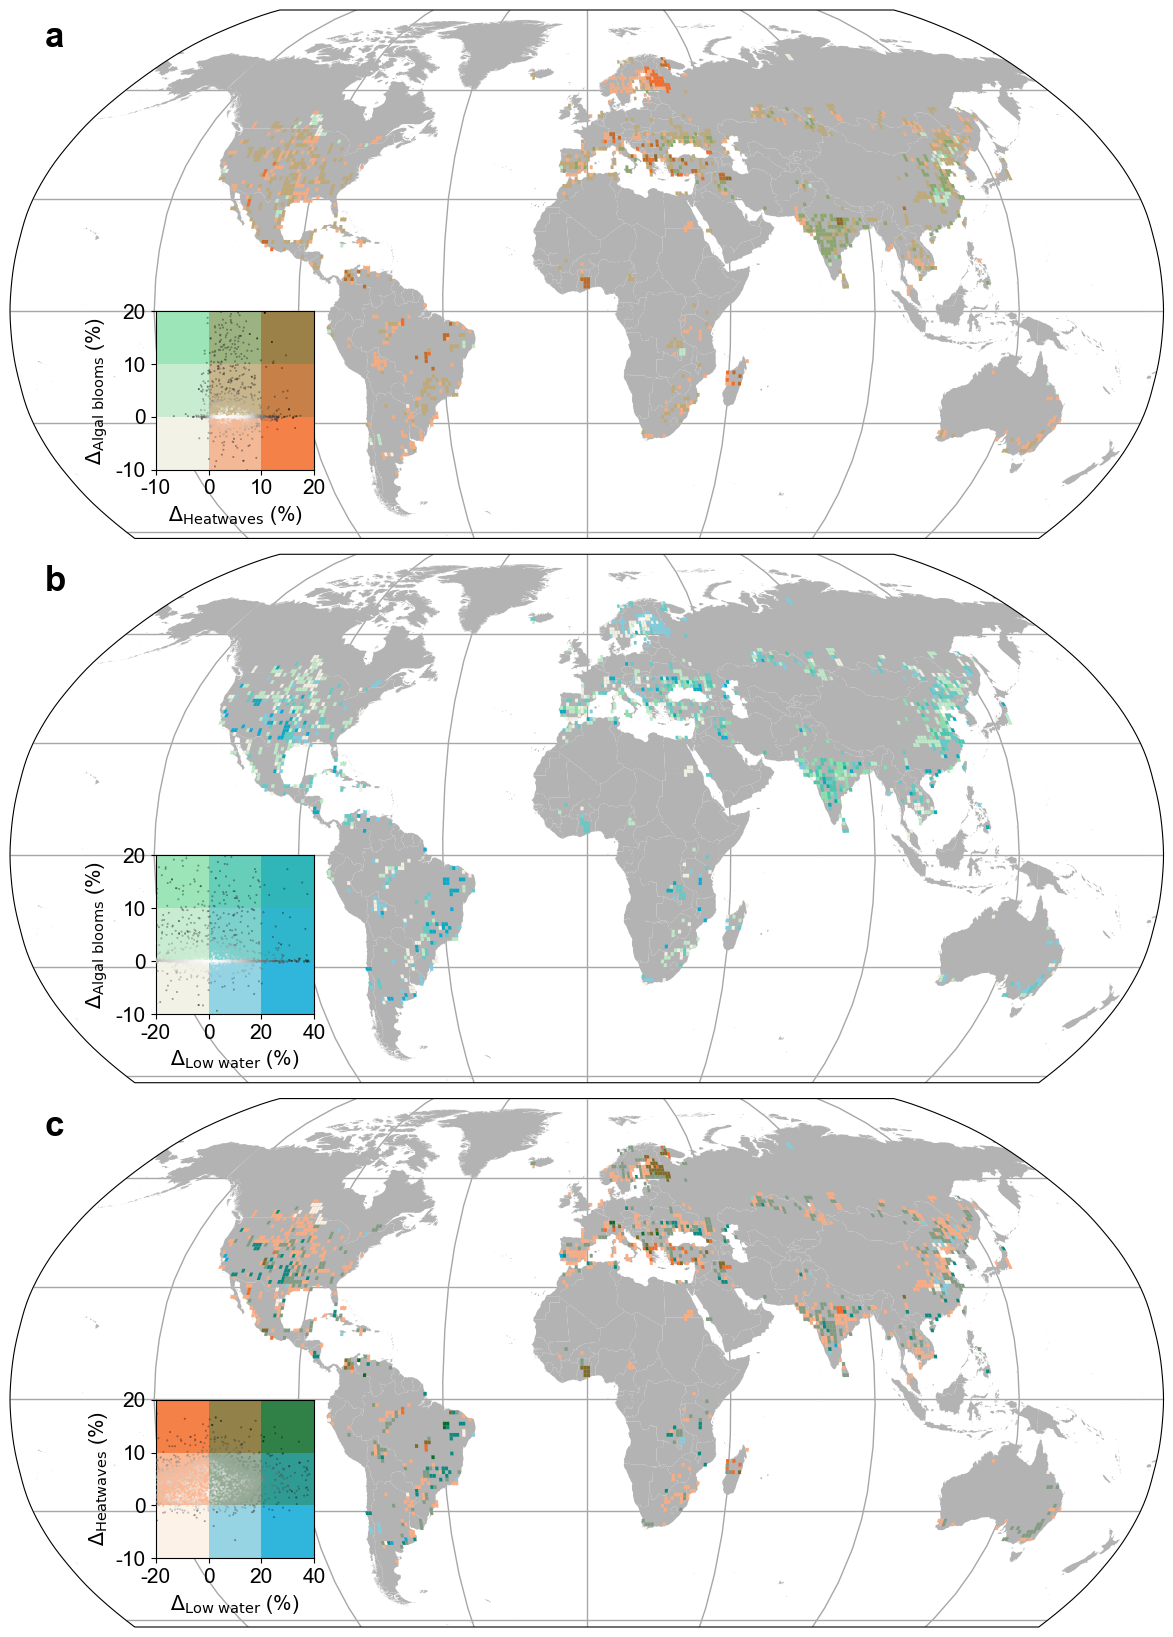

In [6]:
plt.rcParams.update({'font.size': 15})
args = [['delta_heat', 'delta_BO', colorlist1], ['delta_LowEx', 'delta_BO', colorlist2], 
        ['delta_LowEx', 'delta_heat', colorlist3]]
labels = [['Δ$_\mathrm{Heatwaves}$ (%)', 'Δ$_\mathrm{Algal\ blooms}$ (%)'], 
          ['Δ$_\mathrm{Low\ water}$ (%)', 'Δ$_\mathrm{Algal\ blooms}$ (%)'],
          ['Δ$_\mathrm{Low\ water}$ (%)', 'Δ$_\mathrm{Heatwaves}$ (%)']]
seps = {'delta_BO': [-10, 0, 10, 20],
        'delta_heat': [-10,0,10,20],
        'delta_LowEx': [-20,0,20,40]}

fig, axs = plt.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, figsize=(20,21))
axs = axs.ravel()

letters = ['a','b','c']
for k in range(3):
    
    col1, col2, colorlist = args[k]

    bins = len(percentile_bounds)

    col1_sep = seps[col1].copy()
    col2_sep = seps[col2].copy()
    col1_sep[0] = np.min([col1_sep[0], gdf[col1].min()])
    col1_sep[3] = np.max([col1_sep[1], gdf[col1].max()])
    col2_sep[0] = np.min([col2_sep[0], gdf[col2].min()])
    col2_sep[3] = np.max([col2_sep[1], gdf[col2].max()])
    
    gdf['xbin'] = pd.cut(gdf[col1], col1_sep, labels=[0,1,2], include_lowest=True)
    gdf['ybin'] = pd.cut(gdf[col2], col2_sep, labels=[0,1,2], include_lowest=True)

    gdf['color'] = gdf.apply(lambda x: colorlist[int(bins*x['xbin']+x['ybin'])], axis=1)

    ##########################################################################################

    lines2.plot(ax=axs[k], color='#a7a7a7',lw=1, transform=ccrs.PlateCarree(), zorder=1)
        
    world.plot(ax=axs[k], transform=ccrs.PlateCarree(), facecolor='#b3b3b3', edgecolor='#b3b3b3', lw=0, zorder=2)

    gdf.plot(ax=axs[k], transform=ccrs.PlateCarree(), color=gdf['color'], legend=False, 
             marker='o', markersize=10, zorder=3)
    axs[k].set_ylim(-6525154.6651, 8625154.6651)

    axs[k].text(0.03, 0.93, letters[k], weight='bold', fontsize=25, transform=axs[k].transAxes)

    cax = axs[k].inset_axes(bounds=[0.12, 0.13, 0.15, 0.3])
    cax.set_aspect('equal', adjustable='box')
    count = 0
    xticks = [0]
    yticks = [0]
    for i,percentile_bound_p1 in enumerate(percentile_bounds):
        for j,percentile_bound_p2 in enumerate(percentile_bounds):
            percentileboxes = [Rectangle((i,j), 1, 1)]
            pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=0.85)
            count += 1
            cax.add_collection(pc)
            if i == 0:
                yticks.append(percentile_bound_p2)
        xticks.append(percentile_bound_p1)

    cax.set_xlim([0,len(percentile_bounds)])
    cax.set_ylim([0,len(percentile_bounds)])
    cax.set_xticks(list(range(len(percentile_bounds)+1)), xticks)
    cax.set_yticks(list(range(len(percentile_bounds)+1)), yticks)
    cax.set_xticklabels(['{:.0f}'.format(c) for c in seps[col1]])
    cax.set_yticklabels(['{:.0f}'.format(c) for c in seps[col2]])
    cax.set_xlabel(labels[k][0])
    cax.set_ylabel(labels[k][1])
    
    cax1 = cax.inset_axes(bounds=[0, 0, 1, 1])
    x = gdf[col1].values
    y = gdf[col2].values

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    cax1.scatter(x, y, c=z, s=0.1, cmap='Greys_r', alpha=0.6)
    cax1.set_xlim(np.min(seps[col1]), np.max(seps[col1]))
    cax1.set_ylim(np.min(seps[col2]), np.max(seps[col2]))
    cax1.axis('off')
    
        
plt.subplots_adjust(hspace=0.03)